In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes
%matplotlib inline

In [2]:
from glob import glob
from datetime import datetime
from itertools import *
from operator import itemgetter

In [3]:
spec_files = glob('profiling/*/specs')
spec_files.sort()
specs = [np.genfromtxt(f, delimiter=' ', dtype=int)
         for f in spec_files]

In [4]:
lines = ["-","--","-.",":"]
colors = ('blue','black','red','orange','green','magenta','yellow', 'cyan', 'purple', 'firebrick')
colorcycle = cycle(colors)
lastpe = False
line_def = []
color_def = []
for spec in specs:
    pe, comp, impl, mode = (spec[2], spec[4], spec[5], spec[6])
    if not lastpe or lastpe != pe:
        color = next(colorcycle)
        linecycle = cycle(lines)
    line  = next(linecycle)
    lastpe = pe
    line_def.append(line)
    color_def.append(color)

In [5]:
def set_keys(*indices):
    """Returns a function that returns a tuple of key values"""
    def get_keys(seq, indices=indices):
        keys = []
        for i in indices:
            keys.append(seq[i])
        return tuple(keys)
    return get_keys

In [6]:
def get_average_times(dat, dirCol, stepCol, timeCol):
    dat.sort(order=['dir', 'step'])
    result = {}
    for (c_dir, c_step), rows in groupby(dat, key=set_keys('dir','step')):
        #print c_dir, c_step, rows
        c_dir, c_step, total_time, counter = None, None, 0, 0
        for row in rows:
            if not c_dir:
                c_dir = row[dirCol]
            if not c_step:
                c_step = row[stepCol]
            total_time+=row[timeCol]
            counter += 1
        result.setdefault(c_dir, []).append([c_step, total_time*1.0/counter])
    result2 = []
    for c_dir, rows in result.iteritems():
        inner = []
        for row in rows:
            inner.append(row[1])
        result2.append(inner)
    return np.array([np.array(rows) for rows in result2])

In [7]:
def is_axis(a):
    return not type(a) is np.ndarray

In [8]:
g = 'profiling/all-gen-results.csv'
def mkdate(text):
    return datetime.strptime(text, '%Y-%m-%dT%H:%M:%S.%f')
def mkstep(text):
    return int(text[0:2])
gdat = np.genfromtxt(g, delimiter=',', names=True, dtype=('datetime64[us]', int, int, float),
                    converters={'timestamp':mkdate, 'step':mkstep})

Header = ['timestamp', 'dir', 'step', 'ilp-gen']

In [9]:
gdat2 = get_average_times(gdat, 1, 2, 3).transpose()
print 'Loaded %d records (%sx%s unique) = %d runs' % ((len(gdat),) + gdat2.shape + (len(gdat)/gdat2.size,))

Loaded 552 records (8x23 unique) = 3 runs


Header = ['timestamp', 'dir', 'step', 'rows', 'cols', 'non-zero', 'ilp-sol', 'ti-ilp-sol']

In [10]:
s = 'profiling/all-sol-results.csv'
def mkdate(text):
    return datetime.strptime(text, '%Y-%m-%dT%H:%M:%S.%f')
def mkstep(text):
    return int(text[0:2])
sdat = np.genfromtxt(s, delimiter=',', names=True, dtype=('datetime64[us]', int, int, int, int, int, float, float),
                    converters={'timestamp':mkdate, 'step':mkstep})

In [11]:
sdat2 = get_average_times(sdat, 1, 2, 7).transpose()
print 'Loaded %d records (%sx%s unique) = %d runs' % ((len(sdat),) + sdat2.shape + (len(sdat)/sdat2.size,))

Loaded 1656 records (8x23 unique) = 9 runs


In [12]:
MAX_PLOTS_IN_ONE, current_plot, ax_nr, last_res = 6, 0, 0, -1
params = []
for i in xrange(len(specs)):
    current_res = specs[i][2]
    current_plot += 1
    if current_plot > MAX_PLOTS_IN_ONE and last_res != current_res:
        ax_nr += 1
        current_plot = 0
    params.append([ax_nr, gdat2[1:,i], sdat2[:,i],
                   line_def[i], color_def[i], '{2:d} x ({4}*{5}*{6})'.format(*specs[i])])
    last_res = current_res

## ILP-Re-Generation and Solving Time

- ILP-Re-Generation describes the time it takes for the Scheme implementation to evaluate the attribute computing the ILP
    - it does not include the time to read from and write to disk
- ILP Solving describes the time it takes the solver (GLPK in this case) to solve the generated ILP
- the plots show different system configurations
    - a system configuration is given by "r x ( c \* i \* m )", which describes a system with *r* resources and *c* software components with *i* implementations having *m* modes each.
- for one such configuration the same experiment is run, i.e. the system is modified 7 times, whereas only changes on hardware resources are made
- on the x-axis, the steps of this manipulation are shown
    - the initial generation of the ILP (step zero) is only shown below in numbers, as it would skew the diagrams

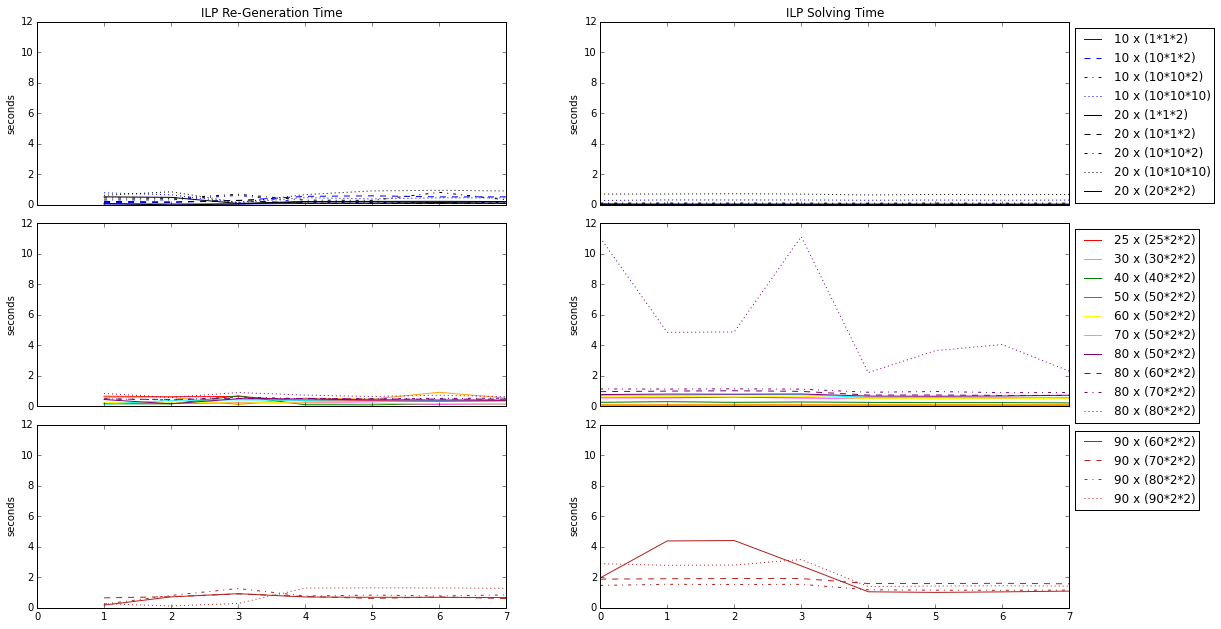

In [13]:
# needed number of axes equals ax_nr+1 now
f, ax_arr = plt.subplots(nrows = ax_nr+1, ncols = 2, sharex=True, sharey=True)
f.set_size_inches(18.5,10.5)
one_plot = ax_arr.shape[1] == 1

lines, labels = [], []
for p in params:
    ax_tup = ax_arr if one_plot else ax_arr[p[0]]
    ax_g = ax_tup[0]
    ax_s = ax_tup[1]
    x_g = np.array(xrange(1,len(p[1])+1)) # start at one, since first gen-time is cut
    l_g = ax_g.plot(x_g, p[1], ls = p[3], c = p[4], label = p[5]) #generation
    l_s = ax_s.plot(p[2], ls = p[3], c = p[4], label = p[5]) #solving
    ax_s.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax_g.set_ylabel('seconds')
    ax_s.set_ylabel('seconds')
    lines.append(l_g[0])
    labels.append(p[5])

first_ax = ax_arr if one_plot else ax_arr[0]
first_ax[0].set_title('ILP Re-Generation Time')
first_ax[1].set_title('ILP Solving Time')

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plots.
f.subplots_adjust(hspace=0.1)
plt.setp([a.get_xticklabels() for a in f.axes[:-2]], visible=False)
plt.setp([a.get_yticklabels() for a in f.axes], visible=True)
plt.show()

## Times for initial generation of the ILP

In [14]:
gdat2[0]

array([  0.62333333,   0.176     ,   1.878     ,  10.858     ,
         0.30666667,   0.32466667,   3.69666667,  23.46566667,
         1.32266667,   2.305     ,   3.26      ,   6.25733333,
        11.05433333,  12.45433333,  16.164     ,  17.56333333,
        22.03433333,  26.25566667,  30.41433333,  29.05033333,
        30.71833333,  38.36      ,  43.84433333])